- colab

In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

# import os
# fname = os.path.join('jena_climate_2009_2016.csv')

- macOS or Windows

In [1]:
import os
data_dir = './datasets/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [2]:
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(f"header: \n{header}\n")
print(f"line length: {len(lines)}")

header: 
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']

line length: 420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [4]:
# from matplotlib import pyplot as plt
# plt.plot(range(len(temperature)), temperature)
# plt.show()

In [5]:
# plt.plot(range(1440), temperature[:1440])
# plt.show()

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras

In [9]:
# DONE generator_test.ipynb
# sampling_rate = 6
# sequence_length = 120
# delay = sampling_rate * (sequence_length + 24 - 1)
# batch_size = 256

# sampling_rate = 3
# sequence_length = 6
# delay = sampling_rate * (sequence_length + 6 - 1)
# batch_size = 2

# train_dataset = keras.utils.timeseries_dataset_from_array(
#     raw_data[:-delay],
#     targets=temperature[delay:],
#     sampling_rate=sampling_rate,
#     sequence_length=sequence_length,
#     shuffle=True,
#     batch_size=batch_size,
#     start_index=0,
#     end_index=num_train_samples)

# for inputs, targets in train_dataset:
#     for i in range(10):
#         print(f"{[x for x in inputs[i]]}\n")
#         print(f"target: {targets[i]}\n")
#         break
#     break

In [10]:
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [12]:
for samples, targets in train_dataset:
    print("sample shape:", samples.shape)
    print("target shape:", targets.shape)
    break

sample shape: (256, 120, 14)
target shape: (256,)


- 상식 수준의 기준점

In [13]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.44
테스트 MAE: 2.62


In [14]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

In [15]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams.update({'mathtext.default':  'default'})
plt.rcParams.update({'font.size': 14})

- 기본적인 머신 러닝 모델 시도 해보기

In [17]:
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Flatten()(inputs)
# x = layers.Dense(16, activation="relu")(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_dense.keras",
#                                     save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=10,
#                     validation_data=val_dataset,
#                     callbacks=callbacks)

# model = keras.models.load_model("jena_dense.keras")
# print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [18]:
# loss = history.history["mae"]
# val_loss = history.history["val_mae"]
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, "bo", label="Training MAE")
# plt.plot(epochs, val_loss, "b", label="Validation MAE")
# plt.title("Training and validation MAE")
# plt.legend()
# plt.show()

In [19]:
# inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# x = layers.Conv1D(8, 24, activation="relu")(inputs)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Conv1D(8, 12, activation="relu")(x)
# x = layers.MaxPooling1D(2)(x)
# x = layers.Conv1D(8, 6, activation="relu")(x)
# x = layers.GlobalAveragePooling1D()(x)
# outputs = layers.Dense(1)(x)
# model = keras.Model(inputs, outputs)

# callbacks = [
#     keras.callbacks.ModelCheckpoint("jena_conv.keras",
#                                     save_best_only=True)
# ]
# model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
# history = model.fit(train_dataset,
#                     epochs=10,
#                     validation_data=val_dataset,
#                     callbacks=callbacks)

# model = keras.models.load_model("jena_conv.keras")
# print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [20]:
# loss = history.history["mae"]
# val_loss = history.history["val_mae"]
# epochs = range(1, len(loss) + 1)
# plt.figure()
# plt.plot(epochs, loss, "bo", label="Training MAE")
# plt.plot(epochs, val_loss, "b", label="Validation MAE")
# plt.title("Training and validation MAE")
# plt.legend()
# plt.show()

- LSTM

In [21]:
print(f"shape: {(sequence_length, raw_data.shape[-1])}")

shape: (120, 14)


In [22]:
# DONE shape & keras.Input
# DONE load_model

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_221211.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 35s 42ms/step - loss: 45.7392 - mae: 4.9378 - val_loss: 13.3670 - val_mae: 2.7744
Epoch 2/10
819/819 [==============================] - 37s 45ms/step - loss: 11.3879 - mae: 2.6135 - val_loss: 9.8664 - val_mae: 2.4592
Epoch 3/10
819/819 [==============================] - 35s 43ms/step - loss: 10.0173 - mae: 2.4651 - val_loss: 9.9695 - val_mae: 2.4587
Epoch 4/10
819/819 [==============================] - 34s 42ms/step - loss: 9.4809 - mae: 2.3904 - val_loss: 10.0504 - val_mae: 2.4465
Epoch 5/10
819/819 [==============================] - 34s 41ms/step - loss: 9.1620 - mae: 2.3474 - val_loss: 10.1485 - val_mae: 2.4548
Epoch 6/10
819/819 [==============================] - 34s 41ms/step - loss: 8.8881 - mae: 2.3133 - val_loss: 10.0441 - val_mae: 2.4421
Epoch 7/10
819/819 [==============================] - 34s 42ms/step - loss: 8.6257 - mae: 2.2820 - val_loss: 10.9377 - val_mae: 2.5148
Epoch 8/10
819/819 [==============================] - 

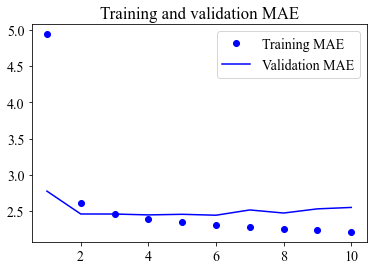

In [23]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [16]:
model = keras.models.load_model("./keras_models/jena_lstm_221211.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 7s 14ms/step - loss: 11.0611 - mae: 2.5991
테스트 MAE: 2.60


- Prediction

In [17]:
# dataset - shuffle=False 
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [18]:
pred_train = model.predict(train_dataset)
pred_val = model.predict(val_dataset)
pred_test = model.predict(test_dataset)

print(f"train shape: {pred_train.shape}")
print(f"val shape  : {pred_val.shape}")
print(f"test shape : {pred_test.shape}")

train shape: (209506, 1)
val shape  : (104393, 1)
test shape : (103537, 1)


In [19]:
x_label = np.arange(pred_train.shape[0] + delay 
                    + pred_val.shape[0] + delay 
                    + pred_test.shape[0] + delay)
                    
# x_label = x_label.reshape(len(x_label), 1)
print(f"x_label shape: {x_label.shape}")

x_label shape: (420010,)


In [20]:
print(f"total sameples: {num_train_samples + num_val_samples + num_test_samples}")

total sameples: 420451


In [21]:
train_start = delay
train_end = train_start + pred_train.shape[0]
x_train = x_label[train_start:train_end]
y_train = temperature[train_start:train_end]

val_start = train_end + delay
val_end = val_start + pred_val.shape[0]
x_val = x_label[val_start:val_end]
y_val = temperature[val_start:val_end]

test_start = val_end + delay
test_end = test_start + pred_test.shape[0]
x_test = x_label[test_start:test_end]
y_test = temperature[test_start:test_end]

In [22]:
print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")

print(f"x_val shape   : {x_val.shape}")
print(f"y_val shape   : {y_val.shape}")

print(f"x_test shape  : {x_test.shape}")
print(f"y_test shape  : {y_test.shape}")

print(f"y_total shape : {y_train.shape[0] + y_val.shape[0] + y_test.shape[0]}")
print(f"temperature shape : {temperature.shape[0]}")

x_train shape : (209506,)
y_train shape : (209506,)
x_val shape   : (104393,)
y_val shape   : (104393,)
x_test shape  : (103537,)
y_test shape  : (103537,)
y_total shape : 417436
temperature shape : 420451


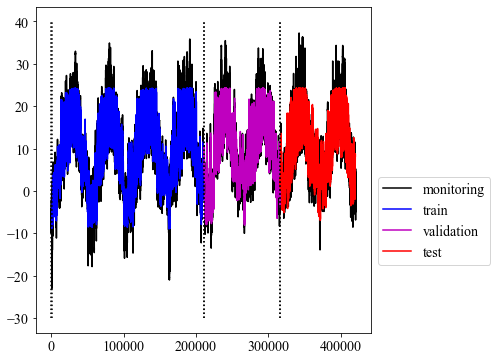

In [23]:
plt.figure(figsize=(6, 6))
# monitoring and prediction grapgh
plt.plot(temperature, 'k')
plt.plot(x_train, pred_train, 'b')
plt.plot(x_val, pred_val, 'm')
plt.plot(x_test, pred_test, 'r')
plt.legend(['monitoring', 'train', 'validation', 'test'], 
            bbox_to_anchor=(1, 0.5))

# time delay (train)
plt.plot([0, 0], [-30, 40], ':k')
plt.plot([delay, train_start], [-30, 40], ':k')
# time delay (validation)
plt.plot([train_end, train_end], [-30, 40], ':k')
plt.plot([val_start, val_start], [-30, 40], ':k')
# time delay (test)
plt.plot([val_end, val_end], [-30, 40], ':k')
plt.plot([test_start, test_start], [-30, 40], ':k')
plt.show()

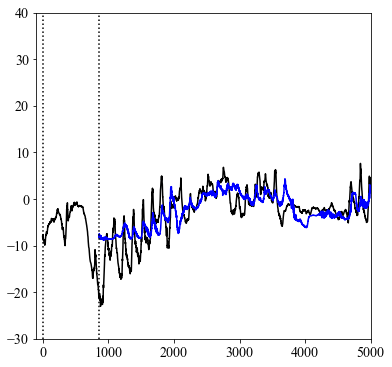

In [28]:
plt.figure(figsize=(6, 6))
# monitoring and prediction grapgh
plt.plot(temperature, 'k')
plt.plot(x_train, pred_train, 'b')

# time delay (train)
plt.plot([0, 0], [-30, 40], ':k')
plt.plot([delay, train_start], [-30, 40], ':k')

plt.axis([-100, 5000, -30, 40])
plt.show()

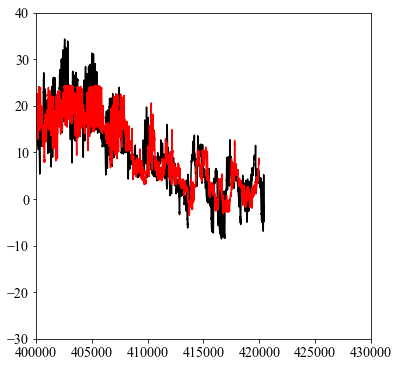

In [34]:
plt.figure(figsize=(6, 6))
# monitoring and prediction grapgh
plt.plot(temperature, 'k')
plt.plot(x_test, pred_test, 'r')

plt.axis([400000, 430000, -30, 40])
plt.show()

In [ ]:
# TODO sensitivity analysis?